In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.decomposition import TruncatedSVD
from scipy.sparse import csr_matrix

df = pd.read_parquet('../01data/02preprocessed/01parquet/df_train.parquet')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2167848 entries, 0 to 2167847
Data columns (total 9 columns):
 #   Column              Dtype         
---  ------              -----         
 0   fecha_compra        datetime64[ns]
 1   customer_id         object        
 2   product_id          object        
 3   type_id             object        
 4   business_id         object        
 5   channel_id          object        
 6   cantidad_venta      float64       
 7   monto_venta_transf  float64       
 8   peso_venta_transf   float64       
dtypes: datetime64[ns](1), float64(3), object(5)
memory usage: 148.9+ MB


In [28]:
# Extract the year and month from 'fecha_compra'
df['year'] = df['fecha_compra'].dt.year
df['month'] = df['fecha_compra'].dt.month

# Define the two periods
period1 = df[(df['year'] == 2022) & (df['month'] == 2)]
period2 = df[(df['year'] == 2023) & (df['month'] == 1)]

# Get the unique customers in each period
customers_period1 = set(period1['customer_id'].unique())
customers_period2 = set(period2['customer_id'].unique())

# Calculate the number of new, retained, and churned customers
new_customers = customers_period2 - customers_period1
retained_customers = customers_period1 & customers_period2
churned_customers = customers_period1 - customers_period2

len(new_customers), len(retained_customers), len(churned_customers)

(3360, 10239, 1006)

In [29]:
# For each customer, calculate the metrics
customer_metrics = df.groupby('customer_id').agg({
    'fecha_compra': ['count', 'min', 'max'],
    'product_id': lambda x: x.nunique()
}).reset_index()

# Rename the columns
customer_metrics.columns = ['customer_id', 'order_count', 'first_order_month', 'last_order_month', 'unique_products']

# Calculate the number of months in which each customer appears
customer_metrics['num_months'] = (customer_metrics['last_order_month'] - customer_metrics['first_order_month']).dt.days // 30

customer_metrics.head()

,customer_id,order_count,first_order_month,last_order_month,unique_products,num_months
0,1,828,2022-02-01,2023-01-28,176,12
1,10,136,2022-02-03,2023-02-02,69,12
2,100,317,2022-02-03,2023-01-24,170,11
3,1000,427,2022-02-01,2023-02-03,197,12
4,10000,63,2022-02-11,2023-02-01,32,11


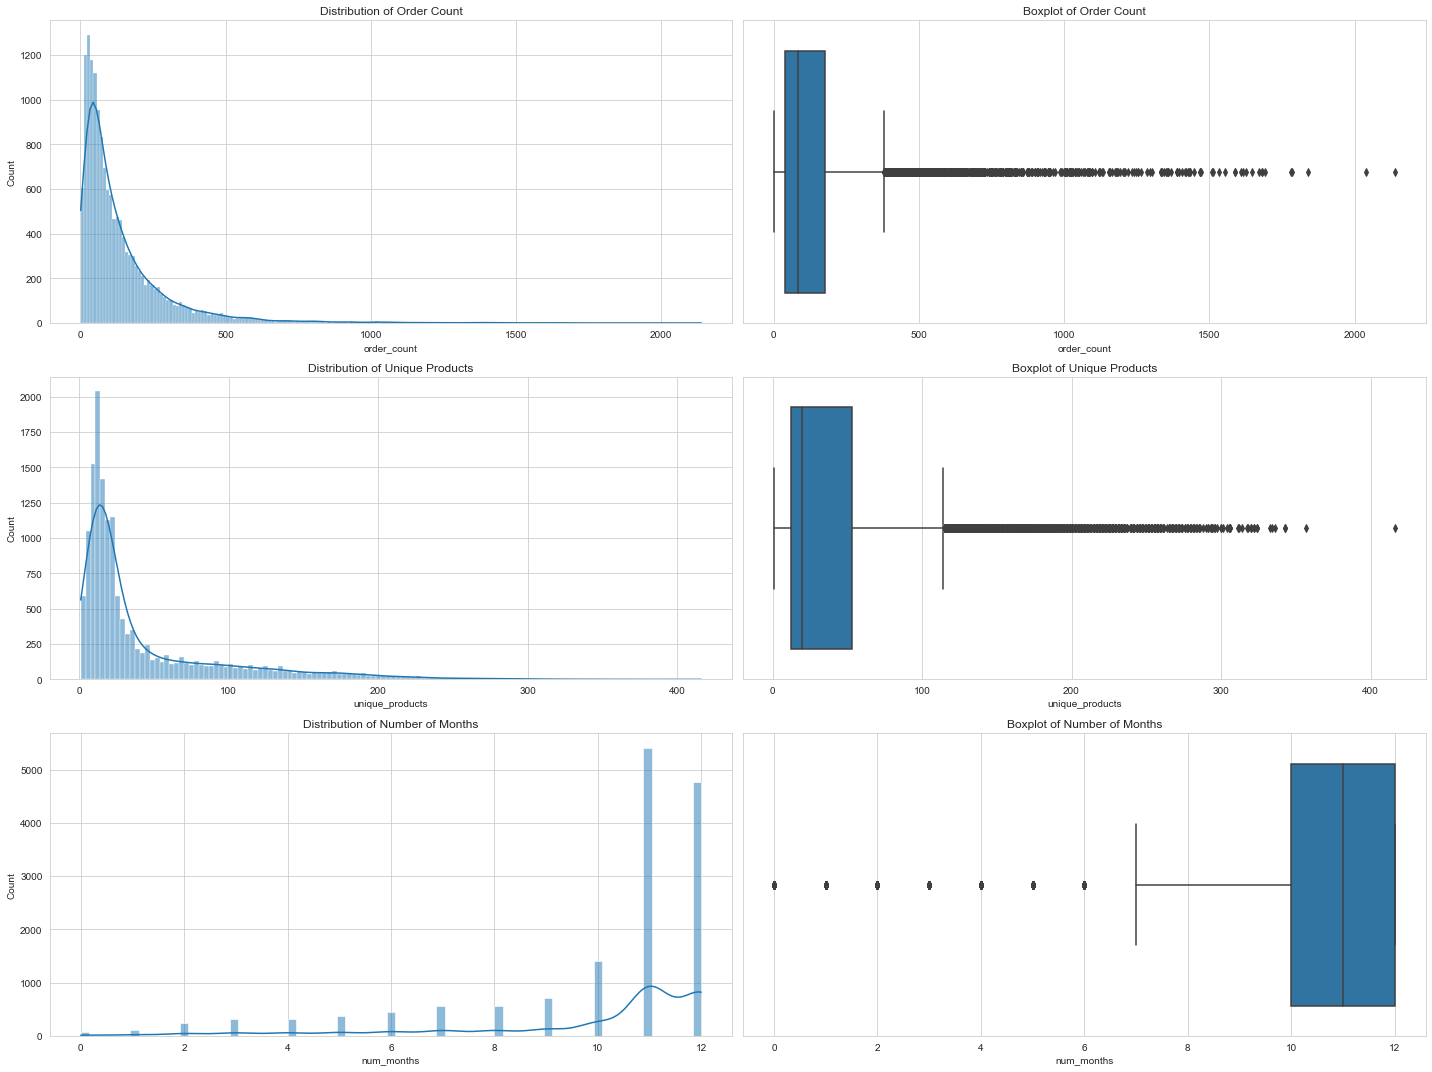

In [30]:
# Let's plot the distributions of the calculated metrics
import matplotlib.pyplot as plt
import seaborn as sns

# Set the style of the plots
sns.set_style("whitegrid")

# Create subplots
fig, axes = plt.subplots(3, 2, figsize=(20, 15))

# Plot the distribution of the order count
sns.histplot(data=customer_metrics, x='order_count', ax=axes[0, 0], kde=True)
sns.boxplot(data=customer_metrics, x='order_count', ax=axes[0, 1])

# Plot the distribution of the unique products
sns.histplot(data=customer_metrics, x='unique_products', ax=axes[1, 0], kde=True)
sns.boxplot(data=customer_metrics, x='unique_products', ax=axes[1, 1])

# Plot the distribution of the number of months
sns.histplot(data=customer_metrics, x='num_months', ax=axes[2, 0], kde=True)
sns.boxplot(data=customer_metrics, x='num_months', ax=axes[2, 1])

# Set the titles
axes[0, 0].set_title('Distribution of Order Count')
axes[0, 1].set_title('Boxplot of Order Count')
axes[1, 0].set_title('Distribution of Unique Products')
axes[1, 1].set_title('Boxplot of Unique Products')
axes[2, 0].set_title('Distribution of Number of Months')
axes[2, 1].set_title('Boxplot of Number of Months')

plt.tight_layout()
plt.show()

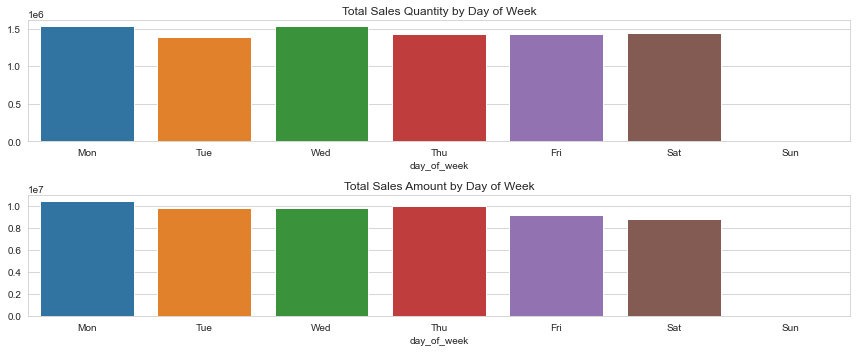

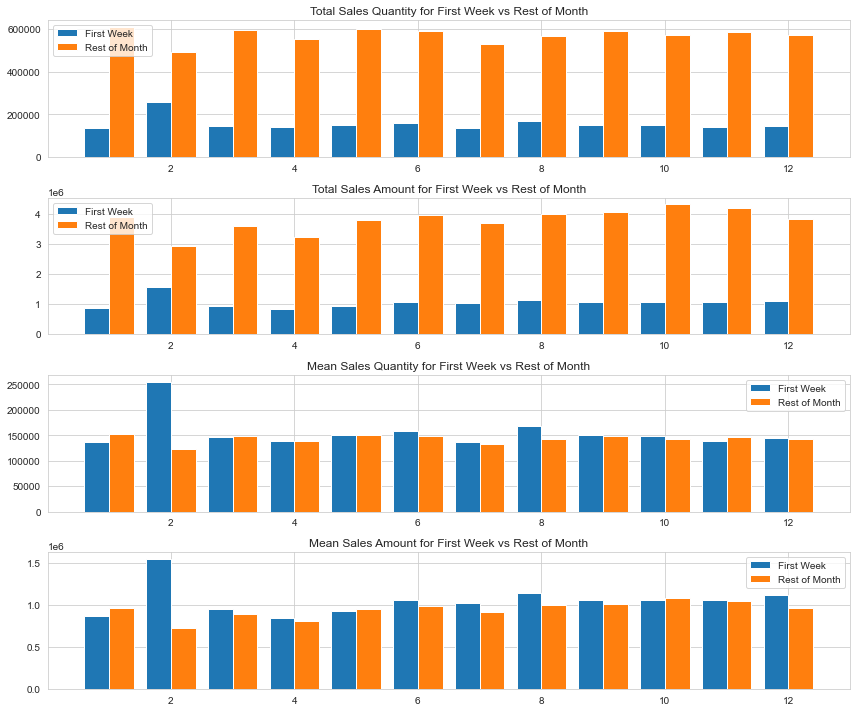

In [55]:
# Importing required libraries
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Function definition
def analyze_sales_data(df):
    # Convert 'fecha_compra' to datetime format
    df['fecha_compra'] = pd.to_datetime(df['fecha_compra'], format='%Y/%m/%d')

    # Extract the day of week from 'fecha_compra'
    df['day_of_week'] = df['fecha_compra'].dt.dayofweek
    df['week_of_month'] = df['fecha_compra'].dt.day // 7

    # Calculate the total sales quantity and amount for each day of the week
    sales_quantity_by_dow = df.groupby('day_of_week')['cantidad_venta'].sum()
    sales_amount_by_dow = df.groupby('day_of_week')['monto_venta_transf'].sum()

    # Generate the bar plots
    fig, axs = plt.subplots(2, 1, figsize=(12, 5))

    sns.barplot(x=sales_quantity_by_dow.index, y=sales_quantity_by_dow.values, ax=axs[0])
    axs[0].set_title('Total Sales Quantity by Day of Week')
    axs[0].set_xticklabels(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])

    sns.barplot(x=sales_amount_by_dow.index, y=sales_amount_by_dow.values, ax=axs[1])
    axs[1].set_title('Total Sales Amount by Day of Week')
    axs[1].set_xticklabels(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])

    plt.tight_layout()
    plt.show()

    # Extract the month from 'fecha_compra'
    df['month'] = df['fecha_compra'].dt.month

    # Calculate the total sales quantity and amount for the first week of each month
    first_week_sales_quantity = df[df['week_of_month'] == 0].groupby('month')['cantidad_venta'].sum()
    first_week_sales_amount = df[df['week_of_month'] == 0].groupby('month')['monto_venta_transf'].sum()

    # Calculate the total sales quantity and amount for the rest of each month
    rest_weeks_sales_quantity = df[df['week_of_month'] != 0].groupby('month')['cantidad_venta'].sum()
    rest_weeks_sales_amount = df[df['week_of_month'] != 0].groupby('month')['monto_venta_transf'].sum()

    # Calculate the mean sales quantity and amount for the rest of each month
    rest_weeks_sales_quantity_mean = df[df['week_of_month'] != 0].groupby(['month','week_of_month'])['cantidad_venta'].sum().groupby('month').mean()
    rest_weeks_sales_amount_mean = df[df['week_of_month'] != 0].groupby(['month','week_of_month'])['monto_venta_transf'].sum().groupby('month').mean()

    # Generate the bar plots
    fig, axs = plt.subplots(4, 1, figsize=(12, 10))

    axs[0].bar(first_week_sales_quantity.index-0.2, first_week_sales_quantity.values, width=0.4, label='First Week')
    axs[0].bar(rest_weeks_sales_quantity.index+0.2, rest_weeks_sales_quantity.values, width=0.4, label='Rest of Month')
    axs[0].set_title('Total Sales Quantity for First Week vs Rest of Month')
    axs[0].legend()

    axs[1].bar(first_week_sales_amount.index-0.2, first_week_sales_amount.values, width=0.4, label='First Week')
    axs[1].bar(rest_weeks_sales_amount.index+0.2, rest_weeks_sales_amount.values, width=0.4, label='Rest of Month')
    axs[1].set_title('Total Sales Amount for First Week vs Rest of Month')
    axs[1].legend()

    axs[2].bar(first_week_sales_quantity.index-0.2, first_week_sales_quantity.values, width=0.4, label='First Week')
    axs[2].bar(rest_weeks_sales_quantity_mean.index+0.2, rest_weeks_sales_quantity_mean.values, width=0.4, label='Rest of Month')
    axs[2].set_title('Mean Sales Quantity for First Week vs Rest of Month')
    axs[2].legend()

    axs[3].bar(first_week_sales_amount.index-0.2, first_week_sales_amount.values, width=0.4, label='First Week')
    axs[3].bar(rest_weeks_sales_amount_mean.index+0.2, rest_weeks_sales_amount_mean.values, width=0.4, label='Rest of Month')
    axs[3].set_title('Mean Sales Amount for First Week vs Rest of Month')
    axs[3].legend()

    plt.tight_layout()
    plt.show()

    return None

# Call the function
analyze_sales_data(df)

* **Ventas totales por día de la semana**: En cuanto a la cantidad de ventas, los días de semana (de lunes a viernes) tienen un comportamiento muy similar, siendo el martes el día con la mayor cantidad de ventas. El fin de semana (sábado y domingo) muestra una disminución notable en las ventas. En términos del monto total de ventas, la tendencia es similar, aunque el jueves supera al martes como el día con el mayor monto de ventas.

* **Ventas totales de la primera semana versus el resto del mes**: Al comparar las ventas de la primera semana de cada mes con las del resto del mes, se observa que las ventas en la primera semana son generalmente más bajas tanto en cantidad como en monto. Sin embargo, al observar el promedio de ventas en la primera semana versus el promedio del resto del mes, vemos que la primera semana tiene un rendimiento similar o incluso superior en algunos meses. Esto sugiere que la primera semana de cada mes puede tener un impacto importante en las ventas totales del mes.

In [51]:
df[df['week_of_month'] != 0].groupby(['month','week_of_month'])['monto_venta_transf'].sum().groupby('month').mean()

month
1     9.688799e+05
2     7.299935e+05
3     8.967794e+05
4     8.032917e+05
5     9.498525e+05
6     9.872734e+05
7     9.211847e+05
8     9.955027e+05
9     1.013312e+06
10    1.077140e+06
11    1.045627e+06
12    9.588753e+05
Name: monto_venta_transf, dtype: float64

In [25]:
df.customer_id.nunique()

15312

In [2]:
# Group the data by 'customer_id' and 'product_id' and sum the 'cantidad_venta'
df_train_grouped = df.groupby(['customer_id', 'product_id'])['cantidad_venta'].sum().reset_index()

# Create a user-product interaction matrix
interaction_matrix = df_train_grouped.pivot(index='customer_id', columns='product_id', values='cantidad_venta')

# Fill missing values with 0
interaction_matrix.fillna(0, inplace=True)

# Convert to csr matrix
interaction_matrix_csr = csr_matrix(interaction_matrix.values)

# Apply SVD
svd = TruncatedSVD(n_components=50, random_state=42)  # 50 components
interaction_matrix_decomposed = svd.fit_transform(interaction_matrix_csr)

# Check the shape of the decomposed matrix
interaction_matrix_decomposed.shape

(15312, 50)

In [5]:
from sklearn.metrics.pairwise import cosine_similarity

# Compute the similarity matrix
similarity_matrix = cosine_similarity(interaction_matrix_decomposed)

# Convert the similarity matrix to a DataFrame
similarity_df = pd.DataFrame(similarity_matrix, index=interaction_matrix.index, columns=interaction_matrix.index)



In [16]:
# Calculate the most sold products
most_sold_products = df.groupby('product_id')['cantidad_venta'].sum().sort_values(ascending=False).head(30).index

# Convert to list
most_sold_products = most_sold_products.tolist()

# Function to get the top-N similar products
def get_top_n_similar_products(customer_id, top_n):
    if customer_id in similarity_df.index:
        # Get the similarity scores for the customer
        similarity_scores = similarity_df[customer_id]

        # Sort the products by similarity score and get the top-N products
        top_n_products = similarity_scores.sort_values(ascending=False).head(top_n).index.tolist()
    else:
        # If the customer_id is not in the similarity matrix, return the most sold products
        top_n_products = most_sold_products

    return top_n_products


# Get the top-50 similar products for each customer
df_submit = df[['customer_id']].drop_duplicates()
df_submit['recommended_products'] = df_submit['customer_id'].apply(lambda x: get_top_n_similar_products(x, 30))

df_submit.head()

,customer_id,recommended_products
0,7157,"[7157, 7621, 607, 5215, 10636, 13918, 3225, 89..."
2,9382,"[9382, 11520, 9363, 11610, 11403, 8195, 11521,..."
5,10355,"[10355, 9437, 9539, 10969, 5377, 9364, 13197, ..."
7,9112,"[9112, 11072, 8518, 12463, 3314, 630, 399, 742..."
9,7298,"[7298, 827, 8764, 955, 11747, 8559, 6421, 1115..."


In [17]:
df_submit.columns = ['customer_id', 'product_id']

In [21]:
## transform column product_id to string replace symbol [ and ,
df_submit['product_id'] = df_submit['product_id'].apply(lambda x: str(x).replace("'", '').replace('[', '').replace(']', '').replace(',', ''))

In [22]:
df_submit.to_parquet('../01data/03result/envio01.parquet', index=False)

In [23]:
df_submit.head()

,customer_id,product_id
0,7157,7157 7621 607 5215 10636 13918 3225 89 6304 36...
2,9382,9382 11520 9363 11610 11403 8195 11521 11974 9...
5,10355,10355 9437 9539 10969 5377 9364 13197 6306 126...
7,9112,9112 11072 8518 12463 3314 630 399 7429 9033 5...
9,7298,7298 827 8764 955 11747 8559 6421 11152 11545 ...


In [26]:
df_submit.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15312 entries, 0 to 2094834
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   customer_id  15312 non-null  object
 1   product_id   15312 non-null  object
dtypes: object(2)
memory usage: 358.9+ KB


In [56]:
# Define the split dates
train_end = pd.to_datetime('2023-01-22')
validation_end = pd.to_datetime('2023-01-29')

# Split the data
train_data = df[df['fecha_compra'] <= train_end]
validation_data = df[(df['fecha_compra'] > train_end) & (df['fecha_compra'] <= validation_end)]
test_data = df[df['fecha_compra'] > validation_end]

train_data.shape, validation_data.shape, test_data.shape

((2084124, 14), (41342, 14), (42382, 14))

In [57]:
from surprise import Dataset, Reader, SVD
from surprise.model_selection import cross_validate, train_test_split
from collections import defaultdict

def get_top_n(predictions, n=50):
    """Return the top-N recommendation for each user from a set of predictions.

    Args:
    predictions(list of Prediction objects): The list of predictions, as
        returned by the test method of an algorithm.
    n(int): The number of recommendation to output for each user. Default
        is 50.

    Returns:
    A dict where keys are user (raw) ids and values are lists of tuples:
        [(raw item id, rating estimation), ...] of size n.
    """

    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n

def recall_at_n(top_n, testset, n=50):
    """Return the recall at n over all users

    Args:
    top_n: A dict of dicts where keys are user (raw) ids and values are
        lists of tuples: [(raw item id, rating estimation), ...] of size n.
    testset: A list of tuples: (user, item, rating).
    n: The number of recommendation to consider per user, 50 by default.

    Returns:
    The recall.
    """

    user_est_true = defaultdict(list)
    for uid, _, true_r in testset:
        user_est_true[uid].append((uid, true_r))

    hits = 0
    total = 0
    for uid, user_ratings in user_est_true.items():
        tmp = set([iid for (iid, _) in user_ratings])
        est = set([iid for (iid, _) in top_n[uid]])
        hits += len(tmp.intersection(est))
        total += len(tmp)

    return hits / total

# Load the trainset in the surprise format
reader = Reader(rating_scale=(df["cantidad_venta"].min(), df["cantidad_venta"].max()))
data = Dataset.load_from_df(df[["customer_id", "product_id", "cantidad_venta"]], reader)

# Split the data into train and test
trainset, testset = train_test_split(data, test_size=0.2)

# Train a SVD model
algo = SVD()
algo.fit(trainset)

# Predict ratings for all pairs (u, i) that are NOT in the training set.
predictions = algo.test(testset)

# Compute top-50 recommendation for each user
top_n = get_top_n(predictions, n=50)

# Compute and print the recall at 50
recall = recall_at_n(top_n, testset, n=50)
print(f'Recall: {recall}')

Recall: 0.001649620587264929


In [60]:
from sklearn.decomposition import TruncatedSVD
from scipy.sparse import csr_matrix
from sklearn.metrics.pairwise import cosine_similarity
from typing import List, Tuple

def create_utility_matrix(data: pd.DataFrame) -> pd.DataFrame:
    """Create a utility matrix from transaction data"""
    utility_matrix = data.pivot_table(values='cantidad_venta', index='customer_id', columns='product_id', fill_value=0)
    return utility_matrix

def svd_based_cf(utility_matrix: pd.DataFrame, n_components: int=50) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """Create user and item latent factor matrices using SVD"""
    # Apply SVD
    svd = TruncatedSVD(n_components=n_components)
    utility_matrix_svd = svd.fit_transform(utility_matrix)

    # Create user and item latent factor matrices
    user_latent_matrix = pd.DataFrame(
        utility_matrix_svd,
        index=utility_matrix.index
    )
    item_latent_matrix = pd.DataFrame(
        svd.components_.T,
        index=utility_matrix.columns
    )

    return user_latent_matrix, item_latent_matrix

def predict_scores(user_latent_matrix: pd.DataFrame, item_latent_matrix: pd.DataFrame) -> pd.DataFrame:
    """Predict scores for each user-item pair"""
    # Calculate user-item scores
    scores = pd.DataFrame(
        np.dot(user_latent_matrix.values, item_latent_matrix.values.T),
        index=user_latent_matrix.index,
        columns=item_latent_matrix.index
    )

    return scores

def get_top_n_items(scores: pd.DataFrame, n: int=50) -> dict:
    """Get top n items for each user"""
    top_n_items = {}
    for user in scores.index:
        top_n_items[user] = scores.loc[user].nlargest(n).index.tolist()

    return top_n_items

def calculate_recall(top_n_items: dict, actual_items: dict, n: int=50) -> float:
    """Calculate average recall"""
    user_recall = []
    for user, recommended_items in top_n_items.items():
        if user in actual_items:
            hits = len(set(recommended_items) & set(actual_items[user]))
            total = len(set(actual_items[user]))
            user_recall.append(hits / total if total != 0 else 0)

    recall = np.mean(user_recall)

    return recall

# Divide the data into train and test based on the date
df_train = df.set_index('fecha_compra')

# Train data is all data before 2023-02-06
df_train_data = df_train.loc[df_train.index < '2023-01-22']

# Test data is all data from 2023-02-06 to 2023-02-12
df_test_data = df_train.loc[(df_train.index >= '2023-01-22') & (df_train.index <= '2023-01-29')]

# Create utility matrix for train data
utility_matrix_train = create_utility_matrix(df_train_data)

# Apply SVD and get user and item latent factor matrices
user_latent_matrix, item_latent_matrix = svd_based_cf(utility_matrix_train)

# Predict scores
scores = predict_scores(user_latent_matrix, item_latent_matrix)

# Get top 50 items for each user
top_50_items = get_top_n_items(scores)

# Calculate average recall
actual_items = df_test_data.groupby('customer_id')['product_id'].apply(list).to_dict()
recall = calculate_recall(top_50_items, actual_items)
print(f'Recall: {recall}')

Recall: 0.6688554210220956


In [62]:
df_test_data.groupby('customer_id')['product_id'].apply(list)

customer_id
1        [510, 848, 752, 116, 999, 743, 285, 294, 343, ...
100                              [96, 203, 1025, 426, 428]
10001                       [203, 356, 282, 276, 280, 146]
10002                                           [659, 252]
10004    [167, 771, 989, 166, 183, 139, 194, 114, 113, ...
                               ...                        
9991                                    [39, 119, 39, 672]
9992                                            [840, 619]
9996                                                 [915]
9997                                  [128, 151, 122, 987]
9998     [147, 497, 659, 439, 11, 195, 129, 53, 167, 88...
Name: product_id, Length: 7906, dtype: object

In [58]:

# Import libraries
from surprise import SVD, Dataset, Reader
from surprise.model_selection import train_test_split
from collections import defaultdict
import pandas as pd

# Create sample data
data = pd.DataFrame({
    'customer_id': ['1', '1', '1', '2', '2', '2', '3', '3', '3'],
    'product_id': ['101', '102', '103', '101', '104', '105', '102', '103', '104'],
    'rating': [5, 4, 5, 3, 2, 5, 4, 5, 3]
})

# Define a function to convert the DataFrame into a Surprise dataset
def df_to_surprise_data(df, reader):
    return Dataset.load_from_df(df[['customer_id', 'product_id', 'rating']], reader)

# Define a function to train the SVD model
def train_svd(data, n_factors=100, n_epochs=20):
    trainset = data.build_full_trainset()
    model = SVD(n_factors=n_factors, n_epochs=n_epochs)
    model.fit(trainset)
    return model

# Define a function to get the top-N recommendations for each user
def get_top_n(predictions, n=10):
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]
    return top_n

# Define a function to calculate the recall
def calculate_recall(top_n, actual):
    recalls = []
    for uid, user_ratings in top_n.items():
        recommended = set([iid for (iid, _) in user_ratings])
        bought = set(actual[uid])
        recalls.append(len(recommended & bought) / len(bought))
    return np.mean(recalls)

# Convert the DataFrame into a Surprise dataset
reader = Reader(rating_scale=(1, 5))
data_surprise = df_to_surprise_data(data, reader)

# Train the SVD model
model = train_svd(data_surprise)

# Get the top-30 recommendations for each user
testset = data_surprise.build_full_trainset().build_anti_testset()
predictions = model.test(testset)
top_n = get_top_n(predictions, n=30)

# Calculate the actual items bought by each user in the last month
actual = data.groupby('customer_id')['product_id'].apply(list).to_dict()

# Calculate the recall
recall = calculate_recall(top_n, actual)
print('Recall:', recall)


Recall: 0.0


In [1]:
import pandas as pd
import helps.log_experiments as log

df_log =  pd.read_parquet('../01data/04log_experiments/experiment_log.parquet')

In [5]:
import os
log_dir = '01data/04log_experiments'
log_file = 'experiment_log.parquet'

# Check if the log file exists
log_path = os.path.join(log_dir, log_file)
print(log_path)

pd.read_parquet(log_path)

01data/04log_experiments\experiment_log.parquet


,id_experimento,tablas_en_memoria,recall_experimento,algoritmos,fecha,additional_info
0,20230730122009,[],0.5,[SVD],2023-07-30 12:20:09.141278,This is a test experiment.
1,20230730122340,[],0.5,[SVD],2023-07-30 12:23:40.139582,This is a test experiment.
2,20230730122459,[],0.5,[SVD],2023-07-30 12:24:59.967193,This is a test experiment.
3,20230730122636,[],0.5,[SVD],2023-07-30 12:26:36.326030,This is a test experiment.


In [3]:
log.log_experiment(0.7, ['SVD'], 'This is a test experiment.')

01data/04log_experiments\experiment_log.parquet


,id_experimento,recall_experimento,algoritmos,fecha,tablas_en_memoria,objetos_en_memoria,additional_info
0,20230730201436,0.7,[SVD],2023-07-30 20:14:36.563165,"[{'name': '_', 'rows': 2, 'cols': 7, 'size': 2...","[{'name': 'In', 'type': 'list', 'size': 96, 'v...",This is a test experiment.


In [4]:
df_log = pd.read_parquet('../01data/04log_experiments/experiment_log.parquet')


In [5]:
df_log

,id_experimento,recall_experimento,algoritmos,fecha,tablas_en_memoria,objetos_en_memoria,additional_info
0,20230730201436,0.7,[SVD],2023-07-30 20:14:36.563165,"[{'name': '_', 'rows': 2, 'cols': 7, 'size': 2...","[{'name': 'In', 'type': 'list', 'size': 96, 'v...",This is a test experiment.


In [21]:
# Import necessary libraries
from IPython import get_ipython
import pandas as pd
import sys
import re

def get_dataframes_in_memory():
    # Get the IPython instance
    ipython = get_ipython()

    # Get all interactive variables
    all_vars = ipython.user_ns

    # Filter out everything that is not a DataFrame
    dataframes = {name: var for name, var in all_vars.items()
                  if isinstance(var, pd.DataFrame)}

    # Create a list of dictionaries, each containing information about one DataFrame
    df_info = [{'name': name, 'rows': df.shape[0], 'cols': df.shape[1], 
                'size': sys.getsizeof(df), 'columns': list(df.columns),
                'first_record': df.iloc[0].to_dict() if not df.empty else None}
               for name, df in dataframes.items() if not re.match(r'^_\d+$', name)]

    return df_info

# Create a DataFrame as an example
df_example = pd.DataFrame(np.random.randn(5,4),
                          index='A B C D E'.split(),
                          columns='W X Y Z'.split())

# Call the function to get information about all DataFrames in memory
dataframes_info = get_dataframes_in_memory()
dataframes_info


[{'name': 'df_log',
  'rows': 4,
  'cols': 6,
  'size': 1720,
  'columns': ['id_experimento',
   'tablas_en_memoria',
   'recall_experimento',
   'algoritmos',
   'fecha',
   'additional_info'],
  'first_record': {'id_experimento': '20230730123353',
   'tablas_en_memoria': array([], dtype=object),
   'recall_experimento': 0.5,
   'algoritmos': array(['SVD'], dtype=object),
   'fecha': Timestamp('2023-07-30 12:33:53.297370'),
   'additional_info': 'This is a test experiment.'}},
 {'name': 'df',
  'rows': 5,
  'cols': 4,
  'size': 466,
  'columns': ['W', 'X', 'Y', 'Z'],
  'first_record': {'W': -0.7863517314425121,
   'X': -0.5425508778935109,
   'Y': 0.2541460286994545,
   'Z': 0.73809104104815}},
 {'name': 'df_example',
  'rows': 5,
  'cols': 4,
  'size': 466,
  'columns': ['W', 'X', 'Y', 'Z'],
  'first_record': {'W': 0.14803548026622446,
   'X': -1.8105972594294604,
   'Y': -0.36161641677972506,
   'Z': -0.032617426628593224}}]

In [25]:
random = 123
nombre = 'Camila'

In [3]:
import re
import sys

def get_other_objects_in_memory():
    # Get the IPython instance
    ipython = get_ipython()

    # Get all interactive variables
    all_vars = ipython.user_ns

    # Filter out everything that is not a DataFrame and does not start with an underscore
    other_objects = {name: var for name, var in all_vars.items()
                     if not isinstance(var, pd.DataFrame) and not re.match(r'^_', name)
                     and type(var).__name__ not in ['module', 'ZMQExitAutocall']}

    # Create a list of dictionaries, each containing information about one object
    obj_info = [{'name': name, 'type': type(obj).__name__, 
                 'size': sys.getsizeof(obj),
                 'value': str(obj)[:100] + '...' if isinstance(obj, (str, list, dict, tuple, set)) else obj}
                for name, obj in other_objects.items()]

    return obj_info

obj_info = get_other_objects_in_memory()

In [10]:
import git
import os
repo = git.Repo(os.path.dirname(os.getcwd()))

In [12]:
repo.git.add(update=True)

''

In [13]:
id_experimento =  'experimento_1'
repo.index.commit(id_experimento)

<git.Commit "ff4abb8e0d5d07aa2ce5322c541f84e6bfa4cde5">

In [16]:
origin = repo.remote(name='origin')
origin.pull()
origin.push()

In [4]:
from kaggle.api.kaggle_api_extended import KaggleApi

In [5]:
api = KaggleApi()
api.authenticate()

In [6]:
api.competitions_list()

[https://www.kaggle.com/competitions/asl-fingerspelling,
 https://www.kaggle.com/competitions/icr-identify-age-related-conditions,
 https://www.kaggle.com/competitions/commonlit-evaluate-student-summaries,
 https://www.kaggle.com/competitions/bengaliai-speech,
 https://www.kaggle.com/competitions/hubmap-hacking-the-human-vasculature,
 https://www.kaggle.com/competitions/google-research-identify-contrails-reduce-global-warming,
 https://www.kaggle.com/competitions/cafa-5-protein-function-prediction,
 https://www.kaggle.com/competitions/kaggle-llm-science-exam,
 https://www.kaggle.com/competitions/rsna-2023-abdominal-trauma-detection,
 https://www.kaggle.com/competitions/playground-series-s3e19,
 https://www.kaggle.com/competitions/titanic,
 https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques,
 https://www.kaggle.com/competitions/spaceship-titanic,
 https://www.kaggle.com/competitions/digit-recognizer,
 https://www.kaggle.com/competitions/nlp-getting-started,
